In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import hilbert
from time import time 
import mat73
from mne.filter import filter_data as filter

# Load empirical Data

In [2]:
# Load Test Data set
data_dict = mat73.loadmat('data/test_data.mat')
signals = data_dict['AAL94_norm']['trial'][0]
fsample = int(data_dict['AAL94_norm']['fsample'])
Time = signals.shape[1]/fsample
print(f'Signal Shape: {signals.shape}, fsample: {fsample}, Time[seconds]: {np.round(Time)}')
data_dict = None

Signal Shape: (94, 119971), fsample: 400, Time[seconds]: 300.0


## Band pass Filter Signal

In [3]:
signals = filter(signals, fsample, 12, 16)

Setting up band-pass filter from 12 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 10.50 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6 dB cutoff frequency: 18.00 Hz)
- Filter length: 441 samples (1.103 sec)



# Calculate the signal envelope

In [4]:
# calculate analytic signal and envelope
analytic_signals = hilbert(signals, axis=-1)
envelopes = np.abs(analytic_signals)
# Centralize envelope
envelopes -= np.mean(envelopes, keepdims=True)
analytic_signals = None
print(f'Envelope Shape: {envelopes.shape}')

Envelope Shape: (94, 119971)


## Plot first 10 seconds of the Signal

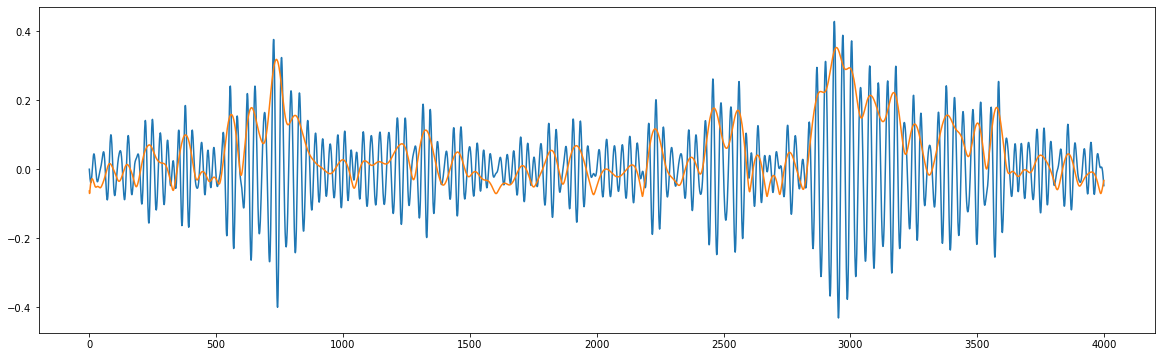

In [5]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(signals[0,:400*10])
ax.plot(envelopes[0,:400*10])

# Apply Lowpass Filter and Downsample Signal

### Define Downsampling Function

In [6]:
def downsampleSignal(data, fsample, resample_num=None, TargetFreq=None):
    from scipy.signal import resample
    if TargetFreq is not None:
        downsamplingFactor = TargetFreq/fsample
        resample_num = int(data.shape[1]*downsamplingFactor)
        print('Resample Number: ', resample_num)

    re_signal = resample(data, num=resample_num, axis=-1)
    return re_signal

In [7]:
DownFreq = 10
LowPassFreq = 0.5
l_envelopes = filter(envelopes, fsample, 0, LowPassFreq)
ld_envelopes = downsampleSignal(l_envelopes, fsample, TargetFreq=DownFreq)
print(f'Envelope Shape after Downsampling: {ld_envelopes.shape}')

Setting up low-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 0.50 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.50 Hz)
- Filter length: 661 samples (1.653 sec)

Resample Number:  2999
Envelope Shape after Downsampling: (94, 2999)


## Plot Envelope before and after Downsampling and Lowpass Filtering

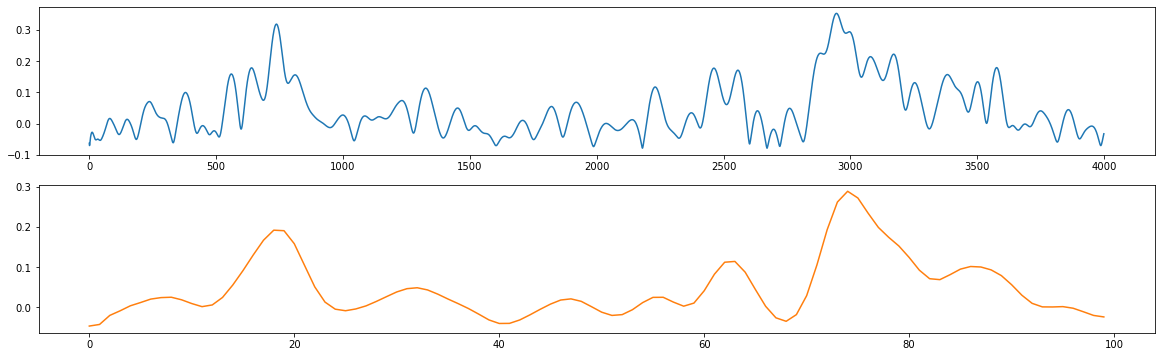

In [8]:
fig, ax = plt.subplots(2,1,figsize=(20,6))
ax[0].plot(envelopes[0,:fsample*10], 'tab:blue')
ax[1].plot(ld_envelopes[0,:DownFreq*10], 'tab:orange')

# Compute CCD 

Following Deco et al. 2017 

### Define Functions 

In [9]:
def calc_v(s):
    #calculate phase of envelope
    analytic = hilbert(s, axis=-1)
    phases = np.angle(analytic)

    #Calculate phase differences 
    diff_phases = [np.abs(phase1-phase2) for phase1 in phases for phase2 in phases]
    diff_phases = np.stack(diff_phases)

    # V is the cosine of the absolute phase differences
    v = np.cos(diff_phases)
    return v, phases, diff_phases

def ccd_fast(v):
    from scipy.linalg import norm
    start = time()
    v_norm = norm(v, axis=0)
    ccd = np.matmul(v.T, v)
    ccd /= v_norm 
    ccd = ccd.T / v_norm 
    print('Time Fast CCD: ',time()-start)
    return ccd 

## Calculate CCD on the empirical dataset

Time Fast CCD:  2.6793177127838135


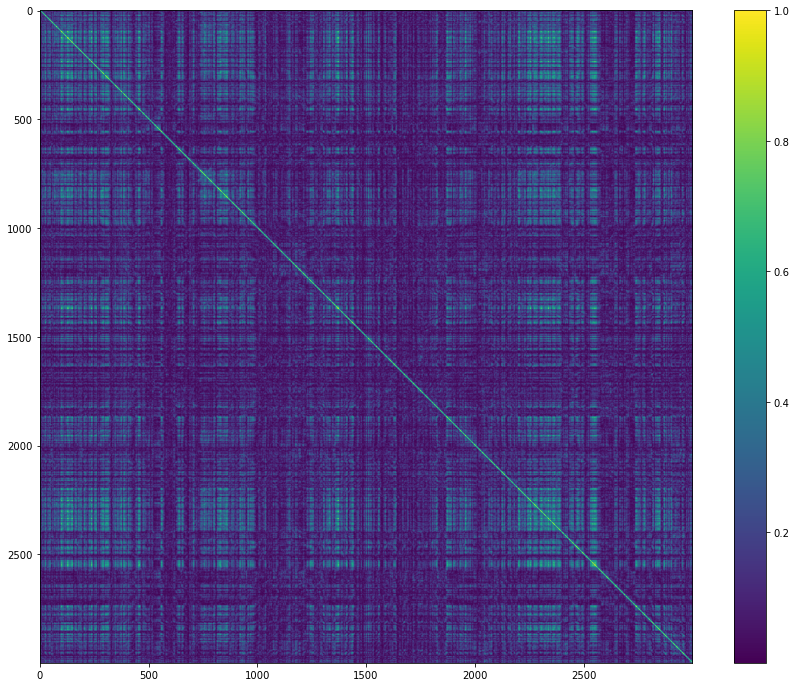

In [10]:
v, phases, diff_phases = calc_v(ld_envelopes)
ccd = ccd_fast(v)
v = None 
fig, ax = plt.subplots(figsize=(15,12))
cax = ax.imshow(ccd, cmap="viridis")
fig.colorbar(cax)
ccd = None

## Smooth CCD 

Use mean of bins to smooth the CCD mat

In [19]:
def smooth(mat, width):
    mat = mat[:,:width*int(mat.shape[1]//width)]
    re_mat = mat.reshape(-1, int(mat.shape[1]/width), width)
    mean_mat = np.mean(re_mat, axis=-1)
    return mean_mat

Time Fast CCD:  0.09349918365478516


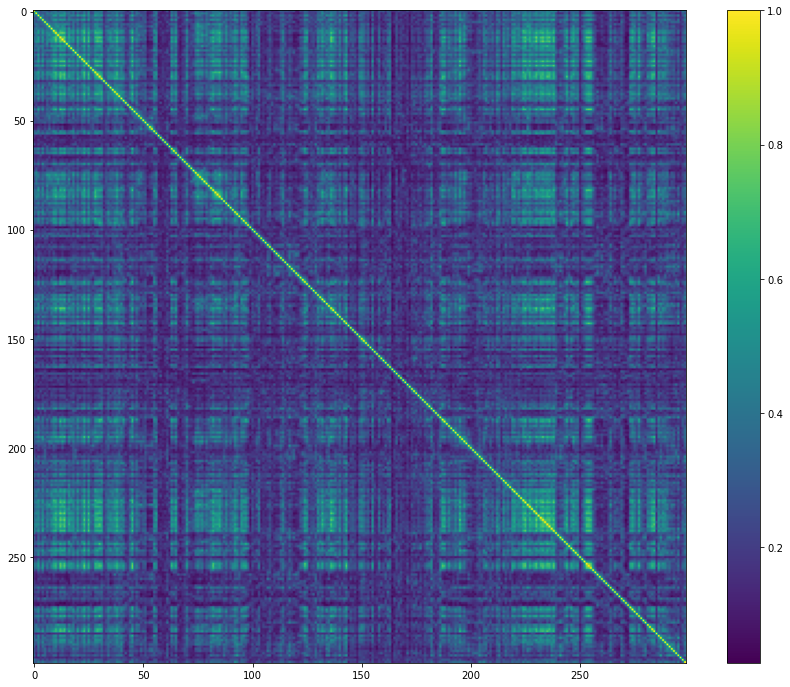

In [20]:
v, phases, diff_phases = calc_v(ld_envelopes)
w = 10
v = smooth(v,w)
ccd = ccd_fast(v)
v = None 
fig, ax = plt.subplots(figsize=(15,12))
cax = ax.imshow(ccd, cmap="viridis")
fig.colorbar(cax)
ccd = None